In [2]:
import torch
import numpy as np
import torch.nn as nn
from torch.nn.modules.loss import MSELoss
from torch.utils.data import dataloader
import utils
from arguments import parse_args
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as T
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tqdm

import wandb
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
import os
from sampling import DelaunayTriangulationBlur
from PIL import Image
import random
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import numba as nb
from torchvision.transforms import ToTensor, ToPILImage

from IPython.display import clear_output as clear

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
args = parse_args( [ "--alg", "MAE"
                   , "--description", "mae-finetune-1000pts-1e-3"
                   , "--lr", "1e-3"
                   , "--epoch", "20"
                   , '--data_root', 'data/celeba'
                   , '--batch_size', '1'
                   , '--point_num', '1000'
                   , '--method', 'center'
                   , '--img_width', '256'
                   , '--img_height', '256'
                   , '--img_size', '256'
                   ])

In [5]:
wandb.init(project=args.description, entity="purewhite2019")
wandb.config = {
  "args" : args,
  "seed" : 31415926
}

# Training Preparation
utils.set_seed_everywhere(31415926)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)




from models.vit import ViT
from models.mae import MAE

img_size, patch_size = (256, 256), (16, 16)

encoder = ViT(img_size, patch_size, depth=6, dim=512, mlp_dim=768, num_heads=8, channels=4) # Simple

model = MAE(encoder, decoder_depth=6, decoder_dim=512, mask_ratio=0.75)
model.to(device)
model.load_state_dict(torch.load('/home/purewhite/workspace/cg-proj/NUG-DLSS/logs/MAE_pretrained.pth'))

optimizer = optim.RAdam(params=model.parameters(),lr=args.lr)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=1000,gamma = 0.5)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: purewhite2019 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


cuda:0


In [130]:
args = parse_args( [ "--alg", "MAE"
                   , "--description", "mae-finetune-1000pts-1e-3"
                   , "--lr", "1e-3"
                   , "--epoch", "20"
                   , '--data_root', 'data/celeba'
                   , '--batch_size', '1'
                   , '--point_num', '1000'
                   , '--method', 'vertex'
                   , '--img_width', '256'
                   , '--img_height', '256'
                   , '--img_size', '256'
                   ])

In [131]:

from sampling.triangulation_blur import DelaunayTriangulationBlur_4Channel
class TrainDataset_4Channel(Dataset):
    def __init__(self, args):
        self.args = args
        self.root_path = os.path.join(args.data_root, 'train')
        self.img_list = os.listdir(self.root_path)
        try:
            self.img_list.remove('.DS_Store')
        except:
            pass
        self.method = args.method
        self.transform_on_hr = self.get_transform('hr')
        self.transform_on_lr = self.get_transform('lr')

    
    def get_transform(self, target):
        if target=='lr':
            trans = transforms.Compose( 
                [transforms.Resize((self.args.img_width,self.args.img_height))]
                # [transforms.CenterCrop((self.args.img_width,self.args.img_height))]
                )
        elif target=='hr':
            trans = transforms.Compose( 
                [transforms.Resize((self.args.img_width,self.args.img_height))]
                # [transforms.CenterCrop((self.args.img_width,self.args.img_height))]
                )
        else:
            raise Exception('Transform not supported.')
        return trans

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_path, self.img_list[idx])
        img_pair = dict()

        img_hr = Image.open(img_path)
        img_lr = self.transform_on_lr(img_hr)
        
        img_hr= np.array(self.transform_on_hr(img_hr))
        img_pair['hr'] = torch.tensor(img_hr, dtype=torch.float32)

        img_lr = DelaunayTriangulationBlur_4Channel(np.array(img_lr), \
            self.args.point_num, self.args.method, sample_point_method='random')
        img_pair['lr'] = torch.tensor(np.array(img_lr), dtype=torch.float32)
        
        img_pair['hr'] /= 255
        # img_pair['lr'] /= 255 # Moved to DelaunayTriangulationBlur_4Channel

        return img_pair
    
    def __len__(self):
        return len(self.img_list)

train_dataset = TrainDataset_4Channel(args)
train_loader = data.DataLoader(dataset=train_dataset,
                                batch_size=args.batch_size,
                                shuffle=True,
                                num_workers=args.num_workers,
                                pin_memory=True,
                                drop_last=True,
                                collate_fn=utils.collect_function,)

torch.Size([256, 256, 4]) torch.Size([256, 256, 3])


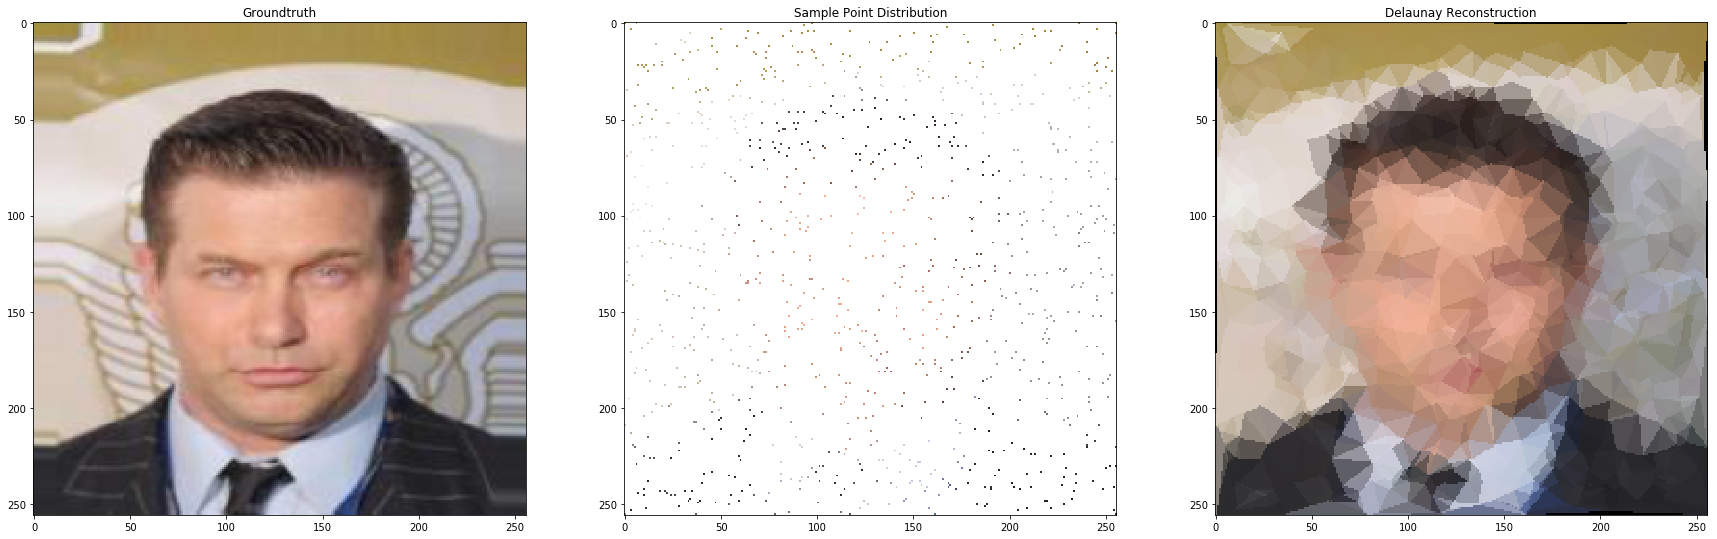

In [132]:
img_pair = train_dataset[3]
img_lr = img_pair['lr']
img_hr = img_pair['hr']

print(img_lr.shape, img_hr.shape)

figsize=(30, 30)
plt.figure(1, figsize=figsize)
plt.subplot(1, 3, 1)
plt.imshow(img_hr)
plt.title('Groundtruth')

plt.figure(1, figsize=figsize)
plt.subplot(1, 3, 2)
plt.imshow(img_lr)
plt.title('Sample Point Distribution')

plt.figure(1, figsize=figsize)
plt.subplot(1, 3, 3)
plt.imshow(img_lr[:, :, :-1])
plt.title('Delaunay Reconstruction')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch: 19 | iter: 399/400 | loss: -1.0119261741638184: 100%|██████████| 400/400 [02:13<00:00,  2.99it/s]


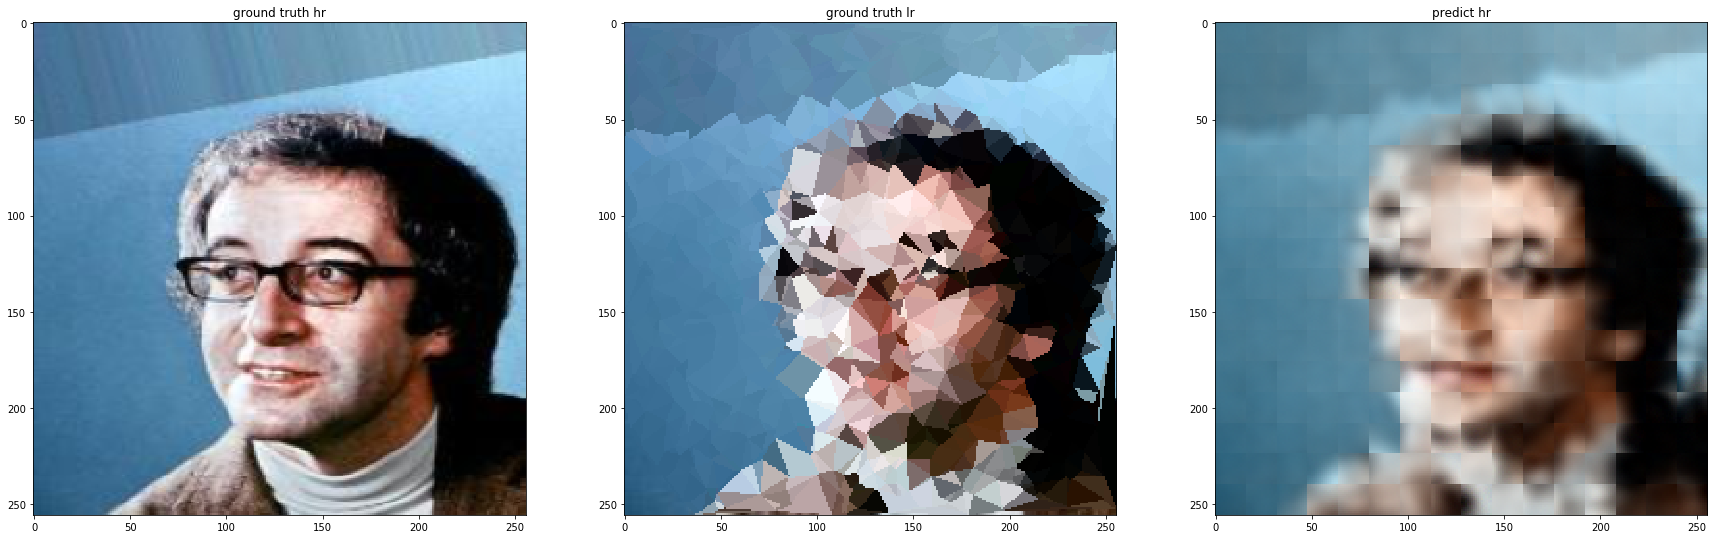

In [8]:

# for _ in range(800): # Default setting in MAE paper
optimizer.zero_grad()
wandb.watch(model)
model.train()
for e in range(args.epoch):
    idx = random.randint(0, len(train_dataset)-1)
    img_pair = utils.collect_function([train_dataset[idx]])

    model.eval()
    clear()
    with torch.no_grad():
        output = model.forward_nomask(img_pair['lr'].to(device))
        img_pred = output.permute(0, 2, 3, 1).cpu().numpy()[:, :, :, :-1]

    img_lr = img_pair['lr'].permute(0, 2, 3, 1).cpu().numpy()[:, :, :, :-1]
    img_hr = img_pair['hr'].permute(0, 2, 3, 1).cpu().numpy()
    utils.show_gt_and_pred(img_hr=img_hr[0], img_lr=img_lr[0], pred_hr=img_pred[0], figsize=(30, 30))
    
    tot_mse = 0
    tot_psnr = 0
    tot_ssim = 0

    tot_lr_mse = 0
    tot_lr_psnr = 0
    tot_lr_ssim = 0
    
    model.train()
    loop = tqdm.tqdm(train_loader)
    for idx, img_pair in enumerate(loop):
        
        x = img_pair['lr'].to(device)
        output = model.forward_nomask(x)
        
        img_pred = output.permute(0, 2, 3, 1)[:, :, :, :-1].permute(0, 3, 1, 2).to(device)
        img_lr = img_pair['lr'].permute(0, 2, 3, 1)[:, :, :, :-1].permute(0, 3, 1, 2).to(device)
        img_hr = img_pair['hr'].to(device)
        
        mse = F.mse_loss(img_hr.reshape((img_hr.shape[0], -1)), img_pred.reshape((img_hr.shape[0], -1)))
        psnr = utils.psnr(img_hr, img_pred)
        ssim = utils.ssim(img_hr, img_pred)
        loss = -psnr/300 - ssim + mse
        
        tot_mse += mse
        tot_psnr += psnr
        tot_ssim += ssim
        
        lr_psnr = utils.psnr(img_hr, img_lr)
        lr_ssim = utils.ssim(img_hr, img_lr)
        lr_mse = F.mse_loss(img_hr.reshape((img_hr.shape[0], -1)), img_lr.reshape((img_hr.shape[0], -1)))
            
        tot_lr_mse += lr_mse
        tot_lr_psnr += lr_psnr
        tot_lr_ssim += lr_ssim
        
        loss = -psnr/300 - ssim + mse
        wandb.log({"psnr improvement": (psnr-lr_psnr)*100/lr_psnr})
        wandb.log({"ssim improvement": (ssim-lr_ssim)*100/lr_ssim})
        wandb.log({"mse improvement": (lr_mse-mse)*100/lr_mse})
        wandb.log({"psnr": psnr})
        wandb.log({"ssim": ssim})
        wandb.log({"mse": mse})
        wandb.log({"loss": loss})
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        loop.set_description(f"epoch: {e} | iter: {idx}/{len(train_dataset)} | loss: {loss.item()}")
    
    e += 1
    utils.save_model(model, e, args)
    

In [12]:
from sampling.triangulation_blur import DelaunayTriangulationBlur_4Channel
class TestDataset_4Channel(Dataset):
    def __init__(self, args):
        self.args = args
        self.root_path = os.path.join(args.data_root, 'test')
        self.img_list = os.listdir(self.root_path)
        try:
            self.img_list.remove('.DS_Store')
        except:
            pass
        self.method = args.method
        self.transform_on_hr = self.get_transform('hr')
        self.transform_on_lr = self.get_transform('lr')

    
    def get_transform(self, target):
        if target=='lr':
            trans = transforms.Compose( 
                [transforms.Resize((self.args.img_width,self.args.img_height))]
                # [transforms.CenterCrop((self.args.img_width,self.args.img_height))]
                )
        elif target=='hr':
            trans = transforms.Compose( 
                [transforms.Resize((self.args.img_width,self.args.img_height))]
                # [transforms.CenterCrop((self.args.img_width,self.args.img_height))]
                )
        else:
            raise Exception('Transform not supported.')
        return trans

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_path, self.img_list[idx])
        img_pair = dict()

        img_hr = Image.open(img_path)
        img_lr = self.transform_on_lr(img_hr)
        
        img_hr= np.array(self.transform_on_hr(img_hr))
        img_pair['hr'] = torch.tensor(img_hr, dtype=torch.float32)

        img_lr = DelaunayTriangulationBlur_4Channel(np.array(img_lr), \
            self.args.point_num, self.args.method, sample_point_method='random')
        img_pair['lr'] = torch.tensor(np.array(img_lr), dtype=torch.float32)
        
        img_pair['hr'] /= 255
        # img_pair['lr'] /= 255 # Moved to DelaunayTriangulationBlur_4Channel

        return img_pair
    
    def __len__(self):
        return len(self.img_list)

test_dataset = TestDataset_4Channel(args)
test_loader = data.DataLoader(dataset=test_dataset,
                                batch_size=args.batch_size,
                                shuffle=True,
                                num_workers=args.num_workers,
                                pin_memory=True,
                                drop_last=True,
                                collate_fn=utils.collect_function,)

In [13]:
model.eval()
tot_mse = 0
tot_psnr = 0
tot_ssim = 0

tot_lr_mse = 0
tot_lr_psnr = 0
tot_lr_ssim = 0

loop = tqdm.tqdm(test_loader)
with torch.no_grad():
    for idx, img_pair in enumerate(loop):
        
        x = img_pair['lr'].to(device)
        output = model.forward_nomask(x)
        
        img_pred = output.permute(0, 2, 3, 1)[:, :, :, :-1].permute(0, 3, 1, 2).to(device)
        img_lr = img_pair['lr'].permute(0, 2, 3, 1)[:, :, :, :-1].permute(0, 3, 1, 2).to(device)
        img_hr = img_pair['hr'].to(device)
        
        mse = F.mse_loss(img_hr.reshape((img_hr.shape[0], -1)), img_pred.reshape((img_hr.shape[0], -1)))
        psnr = utils.psnr(img_hr, img_pred)
        ssim = utils.ssim(img_hr, img_pred)
        loss = -psnr/300 - ssim + mse
        
        tot_mse += mse
        tot_psnr += psnr
        tot_ssim += ssim
        
        lr_psnr = utils.psnr(img_hr, img_lr)
        lr_ssim = utils.ssim(img_hr, img_lr)
        lr_mse = F.mse_loss(img_hr.reshape((img_hr.shape[0], -1)), img_lr.reshape((img_hr.shape[0], -1)))
            
        tot_lr_mse += lr_mse
        tot_lr_psnr += lr_psnr
        tot_lr_ssim += lr_ssim
        
        loop.set_description(f"iter: {idx}/{len(test_loader)} | loss: {loss.item()} | psnr improvement: {(tot_psnr-tot_lr_psnr)*100/tot_lr_psnr} | ssim improvement: {(tot_ssim-tot_lr_ssim)*100/tot_lr_ssim} | mse_decrease: {(tot_lr_mse-tot_mse)*100/tot_lr_mse}")
print(f"Avg.LR_PSNR: {tot_lr_psnr / len(test_loader)} | Avg.LR_SSIM: {tot_lr_ssim / len(test_loader)}")
print(f"Avg.PSNR: {tot_psnr / len(test_loader)} | Avg.SSIM: {tot_ssim / len(test_loader)}")

iter: 99/100 | loss: -0.9288703799247742 | psnr improvement: 2.4601545333862305 | ssim improvement: 13.075417518615723 | mse_decrease: 31.611570358276367: 100%|██████████| 100/100 [00:07<00:00, 13.20it/s]

Avg.LR_PSNR: 68.50552368164062 | Avg.LR_SSIM: 0.6205186247825623
Avg.PSNR: 70.19086456298828 | Avg.SSIM: 0.7016540169715881
